In [ ]:
import pandas as pd
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [ ]:
# Interprération d'une date en format "YYYYMMDD"
def parse_date(_date):
    annee = _date[0:4]
    mois = _date[4:6]
    jour = _date[6:8]
    if mois == '00':
        mois = '07'
    if jour == '00':
        jour = '01'
    if annee == '0000':
        return None
    return datetime(int(annee), int(mois), int(jour))

In [ ]:
# Calcul de l'age révolu à la date du décès
def age_revolu(date_naissance, date_deces):
    _date_naissance = parse_date(date_naissance)
    _date_deces = parse_date(date_deces)
    if _date_naissance and _date_deces:
        _age_revolu = int((_date_deces - _date_naissance).days/365)
        return _age_revolu, _date_naissance, _date_deces
    else:
        return None, None, None

In [ ]:
# Expression régulière pour interpréter une ligne du fichier de décès INSEE
_regexp = r'([A-Z\s\-\'\*]+)\/\s*([12])([0-9]{8})([0-9AB]{5})(.+[^0-9])([0-9]{8})([0-9AB]{5})\s*([0-9]*)'
_pattern = re.compile(_regexp)

In [ ]:
def parse(_string, annee_fichier):
    _match = _pattern.match(_string)
    if _match:
        _age_revolu, _date_naissance, _date_deces = age_revolu(_match[3], _match[6])
        return {'NOM_PRENOMS': _match[1],
                'SEXE': "H" if _match[2] == "1" else "F",
                'DATE_NAISSANCE': _date_naissance,
                'COMM_NAISSANCE': _match[4],
                'LIEU_NAISSANCE': _match[5],
                'DATE_DECES': _date_deces,
                'COMM_DECES': _match[7],
                'ID': _match[8],
                'AGE_REVOLU': _age_revolu,
                'ANNEE': int(_match[6][0:4]),
                'ANNEE_FICHIER': annee_fichier
               }

In [ ]:
# Exemple
parse('OSWALD*ANNA/                                                                    21928030599109LORRACH                       ALLEMAGNE                     201912071410020                ', 2020)

{'AGE_REVOLU': 91,
 'ANNEE': 2019,
 'ANNEE_FICHIER': 2020,
 'COMM_DECES': '14100',
 'COMM_NAISSANCE': '99109',
 'DATE_DECES': datetime.datetime(2019, 12, 7, 0, 0),
 'DATE_NAISSANCE': datetime.datetime(1928, 3, 5, 0, 0),
 'ID': '20',
 'LIEU_NAISSANCE': 'LORRACH                       ALLEMAGNE                     ',
 'NOM_PRENOMS': 'OSWALD*ANNA',
 'SEXE': 'F'}

In [ ]:
fichiers_insee_deces = {
    2020: 'https://www.data.gouv.fr/fr/datasets/r/a1f09595-0e79-4300-be1a-c97964e55f05',
    2019: 'https://www.data.gouv.fr/fr/datasets/r/02acf8f5-9190-4f8e-a37c-3b34eccac833',
    2018: 'https://www.data.gouv.fr/fr/datasets/r/c2a97b38-5c0d-4f21-910f-1cea164c2c89',
    2017: 'https://www.data.gouv.fr/fr/datasets/r/fd61ff96-1e4e-450f-8648-3e3016edbe34',
    2016: 'https://www.data.gouv.fr/fr/datasets/r/8fb032c1-b81e-46c4-a48a-15380ce41e40',
}

In [ ]:
# Récupration et lecture des fichiers de décès INSEE
_dataframes = {annee_fichier: pd.read_csv(_fichier, sep='\t', header=None, encoding='latin1')
               for annee_fichier, _fichier in fichiers_insee_deces.items()}

deces = pd.concat([pd.DataFrame([x for x in df[0].map(lambda x: parse(x, annee_fichier)) if x])
                   for annee_fichier, df in _dataframes.items()])

In [ ]:
# Elimination des quelques lignes dont les informations sont inexploitables
deces = deces.query('AGE_REVOLU==AGE_REVOLU and SEXE==SEXE and ANNEE==ANNEE')
print('Seulement', sum([df.shape[0] for df in _dataframes.values()]) - deces.shape[0],
      'décès inexploitables parmi',
      sum([df.shape[0] for df in _dataframes.values()]))

Seulement 19 décès inexploitables parmi 3141664


In [ ]:
deces.to_csv('deces.csv.gz', compression='gzip')

In [ ]:
# Limitation au décès survenus en France metropolitaine
deces_metro = deces[~deces['COMM_DECES'].str.startswith('99')]
# Suppression des données du 29 Février 2020, seule année bissextile
deces_metro = deces_metro[deces_metro['DATE_DECES'] != '20200229']

In [ ]:
# 99.5% des décès metropolitains hors décembre d'une année sont remontés dans le fichier de la même année
for annee in [2016, 2017, 2018]:
    deces_annee_n_hors_decembre = deces_metro.query(f'DATE_DECES>="{annee}-01-01" and DATE_DECES<"{annee}-12-01"')
    fichier_n_plus = deces_annee_n_hors_decembre.query(f'ANNEE_FICHIER=={annee+1}')['DATE_DECES'].count()
    fichier_n_plus += deces_annee_n_hors_decembre.query(f'ANNEE_FICHIER=={annee+2}')['DATE_DECES'].count()
    fichier_n_plus += deces_annee_n_hors_decembre.query(f'ANNEE_FICHIER=={annee+3}')['DATE_DECES'].count()
    print(1 - fichier_n_plus/deces_annee_n_hors_decembre.shape[0])

0.9974689857704891
0.9959582503779498
0.9972188466983201


In [ ]:
# Re-definition de l'année de décès comme l'année de la (date de deces + 31 jours), afin de capturer au moins 99.5% des décès par année glissante
deces_metro['ANNEE'] = deces_metro['DATE_DECES'].map(lambda _date: (_date + timedelta(days=31)).year)

In [ ]:
# Pyramide des ages par sexe en France métropolitaine, celle de 2016 n'est pas facilement disponible
pyramides_metro = {
    annee: pd.read_excel(f'https://www.insee.fr/fr/statistiques/fichier/1913143/pyramide-des-ages-{annee}.xls', sheet_name=f'{annee} Métro')[5:-2]
    for annee in [2017, 2018, 2019, 2020]
}

In [ ]:
# Quelques reformatages
for annee, df in pyramides_metro.items():
    df.columns = ['ANNEE_NAISSANCE', 'AGE_REVOLU', 'NB_H', 'NB_F', 'NB']
    df['ANNEE'] = annee
    df['AGE_REVOLU'] = df['AGE_REVOLU'].astype(int)

In [ ]:
# Concaténation pour avoir un seul dataframe
pyramide_metro_orig = pd.concat(pyramides_metro.values())

In [ ]:
# Reformatage pour avoir une ligne par année, age révolu et sexe
df_h = pyramide_metro_orig[['ANNEE', 'AGE_REVOLU', 'NB_H']].rename(columns={'NB_H': 'NB'})
df_h['SEXE'] = "H"
df_f = pyramide_metro_orig[['ANNEE', 'AGE_REVOLU', 'NB_F']].rename(columns={'NB_F': 'NB'})
df_f['SEXE'] = "F"
pyramide_metro = pd.concat([df_h, df_f])

In [ ]:
# Aggrégation des décès par année, age révolu (jusqu'à 96 ans) et sexe
deces_metro_agg = deces_metro.groupby(['AGE_REVOLU', 'ANNEE', 'SEXE'])['DATE_DECES'].count().reset_index()
deces_metro_agg = deces_metro_agg.query('AGE_REVOLU < 97')
deces_metro_agg.columns = ['AGE_REVOLU', 'ANNEE', 'SEXE', 'NB_DECES']

In [ ]:
# Jointure entre les pyrmides d'âge et les décès par age révolu
_merge = deces_metro_agg.merge(pyramide_metro)

In [ ]:
# Retourne les taux de mortalité par age révolu pour une année et un sexe donnés
def mortalite_par_age(df, annee, sexe):
    _df = df[(df['ANNEE'] == annee) & (df['SEXE']==sexe)]
    _df = _df.set_index(_df['AGE_REVOLU'])
    return pd.DataFrame(_df['NB_DECES'] / _df['NB'], columns=[f'MORTALITE_{annee}_{sexe}'])

In [ ]:
# Calcul des series de taux de mortalité pour toutes les combinaisons d'année et sexe
taux_mortalite = pd.concat([mortalite_par_age(_merge, annee, sexe)
                            for annee in [2020, 2019, 2018, 2017]
                            for sexe in ["H", "F"]], axis=1)

In [ ]:
# Enrichissement avec la pyramide d'age 2020 et la mortalité max et min observée entre 2017 et 2019
for sexe in ["H", "F"]:
    taux_mortalite[f'NB_2020_{sexe}'] = _merge.query(f'SEXE=="{sexe}" and ANNEE==2020').set_index('AGE_REVOLU')['NB']
    taux_mortalite[f'MORTALITE_MAX_{sexe}'] =taux_mortalite[[f'MORTALITE_{annee}_{sexe}'
                                                             for annee in [2017, 2018, 2019]]].max(axis=1)
    taux_mortalite[f'MORTALITE_MIN_{sexe}'] = taux_mortalite[[f'MORTALITE_{annee}_{sexe}'
                                                              for annee in [2017, 2018, 2019]]].min(axis=1)
    # Différence entre la mortalité 2020 et celle hypothétique 2020 avec les taux 2017
    print(f'Exces de mortalité {sexe} 2020 par rapport à 2017 :', int(taux_mortalite[f'NB_2020_{sexe}'].multiply(
    (taux_mortalite[f'MORTALITE_2020_{sexe}'] - taux_mortalite[f'MORTALITE_2017_{sexe}'])).sum()))

Exces de mortalité H 2020 par rapport à 2017 : 7261
Exces de mortalité F 2020 par rapport à 2017 : 606


In [ ]:
title = """
Taux de mortalité INSEE par age révolu en France métropolitaine
(environ 600.000 personnes décédées par an)

L'Exces de mortalité 2020 par rapport à 2017 (année qui a connu une forte grippe)
= Différence entre la mortalité 2020 et celle hypothétique 2020 avec les taux de 2017 :

7261 Hommes
606 Femmes

Note: Vu que les décès de Décembre 2020 ne sont pas encore tous remontés,
l'analyse est faite sur les décès en année glissante du 1er déc. N-1 au 30 nov. N
"""

In [ ]:
# Traçage de courbe
plt.rcParams["figure.figsize"] = (15,15)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.clf()
plt.cla()
plt.close()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


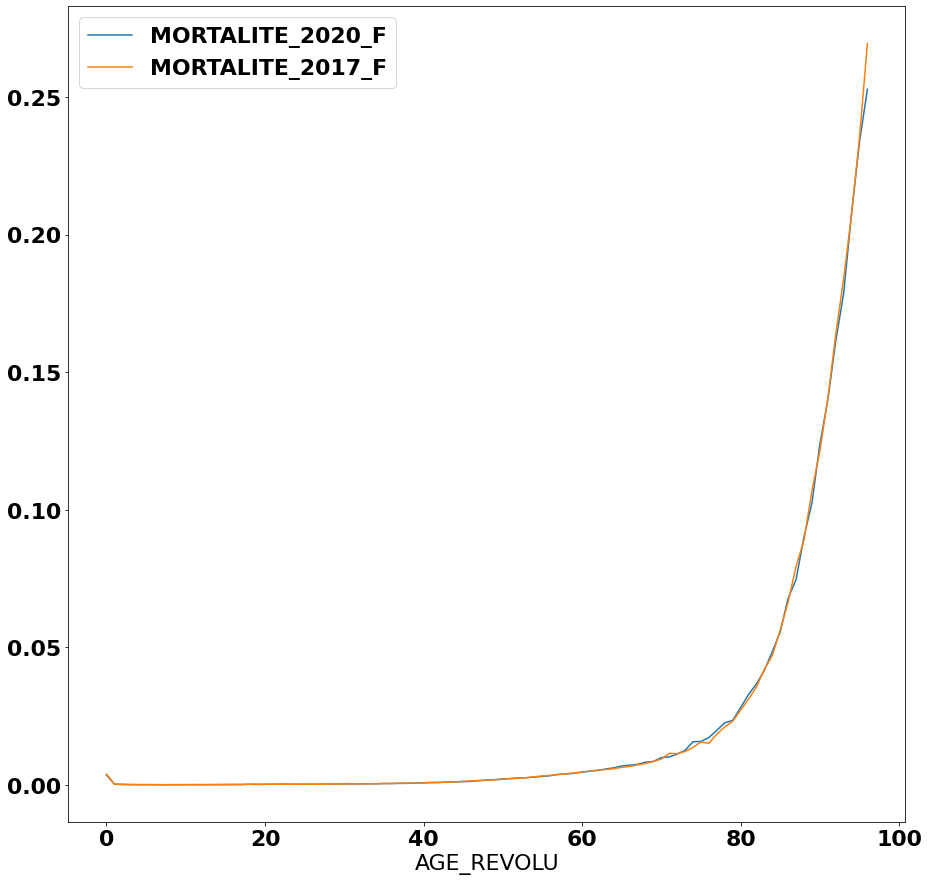

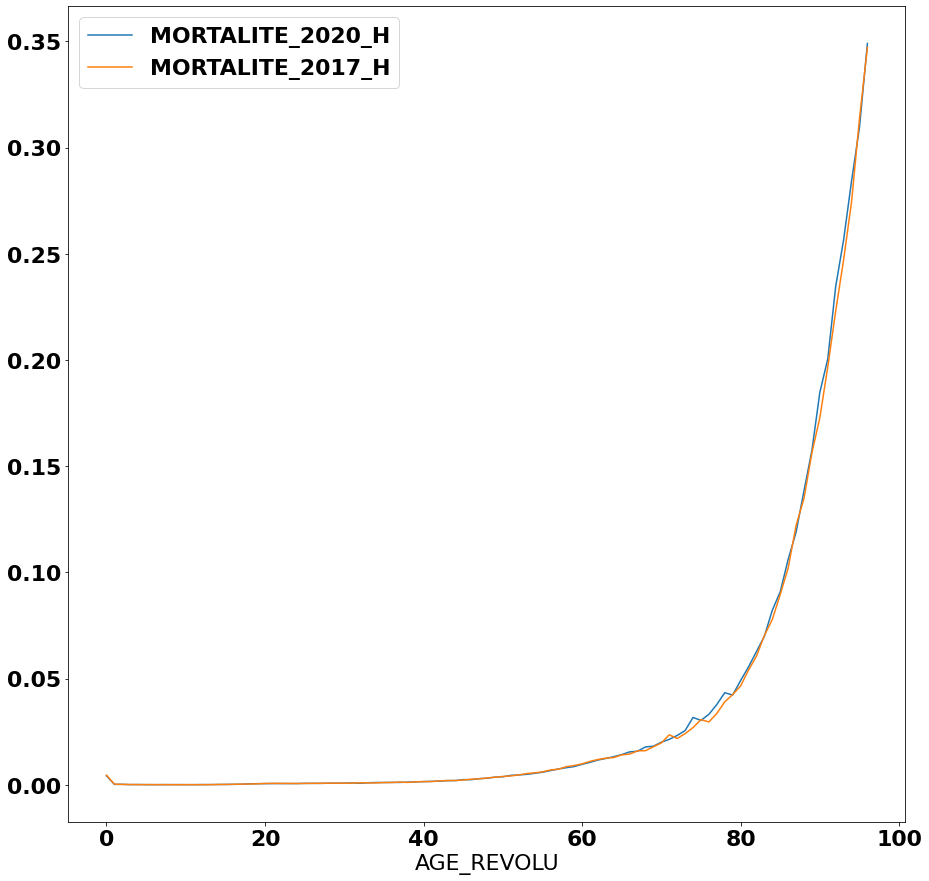

In [ ]:
taux_mortalite[[f'MORTALITE_{annee}_F' for annee in ['2020', '2017']]].plot()
taux_mortalite[[f'MORTALITE_{annee}_H' for annee in ['2020', '2017']]].plot()